In [180]:
import parselmouth
from parselmouth.praat import call
import csv
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
DATA_DIR = "hw3_speech_files/"
speaker = ("cc", "cl", "gg", "jg", "mf", "mk", "mm")
emotions = ("anxiety", "boredom", "cold-anger", "contempt", "despair", "disgust", 
            "elation", "happy", "hot-anger", "interest", "neutral", "panic", "pride", "sadness", "shame")


def extract_features(file_name):
    features = dict()
    speaker, session, emotion, start_time, transcript = file_name.split("_")
    features["speaker"] = speaker
    features["emotion"] = emotion

    sound = parselmouth.Sound(f"{DATA_DIR}/{file_name}")
    
    # convert to mono (left channel)
    sound_mono = call(sound, "Extract one channel", 1)
    
    # extract pitch (75~600 Hz)
    pitch = call(sound_mono, "To Pitch (ac)", 0.0, 75, 15, False, 0.03, 0.45, 0.01, 0.35, 0.14, 600.0)

    # extract intensity
    intensity = call(sound_mono, "To Intensity", 100, 0, "yes")

    # pitch min, max, mean
    features["min_pitch"] = call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")
    features["max_pitch"] = call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")
    features["mean_pitch"] = call(pitch, "Get mean", 0, 0, "Hertz")

    # intensity min, max, mean
    features["min_intensity"] = call(intensity, "Get minimum", 0, 0, "parabolic")
    features["max_intensity"] = call(intensity, "Get maximum", 0, 0, "parabolic")
    features["mean_intensity"] = call(intensity, "Get mean", 0, 0, "energy")
    
    return features

# header
feature_header = [
    "speaker",
    "emotion",
    "min_pitch",
    "max_pitch",
    "mean_pitch",
    "min_intensity",
    "max_intensity",
    "mean_intensity",
]

In [21]:
with open("hw3_features.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=feature_header)
    writer.writeheader()
    for file in tqdm(os.listdir(DATA_DIR)):
        writer.writerow(extract_features(file))

100%|███████████████████████████████████████| 2324/2324 [02:32<00:00, 15.29it/s]


In [122]:
# read feature file to pandas df
df = pd.read_csv("hw3_features.csv")

In [123]:
df.head(10)

,speaker,emotion,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
0,mf,interest,124.115001,397.018336,293.744096,33.579366,69.733383,62.945197
1,mf,anxiety,146.878081,240.369124,164.445183,42.312602,73.748256,68.540534
2,cc,pride,94.326393,200.025755,122.177421,17.928240,64.273383,55.487919
3,cc,boredom,88.463913,218.533760,128.609178,19.371801,67.532694,60.603200
4,jg,panic,144.254547,234.617666,178.339942,26.520651,63.370288,51.328006
5,mm,cold-anger,124.532453,153.122559,146.538572,24.294950,70.574122,61.508323
6,cl,neutral,77.335395,104.401442,87.450552,12.509367,70.896997,61.270589
7,gg,contempt,112.219807,364.056043,216.342487,30.894126,77.645512,70.290472
8,cl,elation,105.517152,354.755770,267.423343,9.746634,86.717652,76.643941
9,mk,interest,198.680568,282.905092,229.217873,28.146478,77.638618,68.237238


In [124]:
df_norm = copy.deepcopy(df)
for feature in df.columns[2:]:
    df_norm[feature] = df.apply(lambda x: x[feature] \
                           - df[(df.emotion=="neutral") & (df.speaker == x["speaker"])][feature].mean(), axis=1)

In [125]:
df_norm

,speaker,emotion,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
0,mf,interest,23.017210,265.439267,183.419993,14.307121,3.132901,3.784808
1,mf,anxiety,45.780290,108.790055,54.121080,23.040357,7.147774,9.380145
2,cc,pride,11.235034,3.116313,19.400483,-16.143483,-10.901426,-13.041479
3,cc,boredom,5.372554,21.624318,25.832241,-14.699922,-7.642115,-7.926199
4,jg,panic,19.214906,-132.674297,-31.025044,-2.788715,-9.595104,-11.656654
...,...,...,...,...,...,...,...,...
2319,cl,despair,1.422995,11.255839,17.570098,2.903587,9.192064,9.020923
2320,cl,anxiety,1.307695,25.345905,9.930004,0.641683,6.575894,5.617413
2321,mf,happy,102.039965,281.704403,226.533971,17.280435,26.075930,25.189442
2322,cc,shame,14.111326,-36.175285,25.072410,-11.479582,-3.949466,-4.342746


In [144]:
df.groupby("emotion").mean()

,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
emotion,,,,,,
anxiety,139.519036,318.443618,196.226813,29.681230,73.017183,64.305448
boredom,107.906437,241.212688,153.169408,30.649566,73.811751,65.720050
cold-anger,128.728756,328.074332,211.331563,27.222650,77.569301,67.821275
contempt,116.463269,278.861723,177.388262,27.268256,74.626012,65.580252
despair,156.664091,360.687198,235.610307,29.394986,75.563072,66.841680
disgust,123.233954,343.607685,206.376359,28.018613,77.844994,68.845897
elation,199.548581,436.769639,317.567833,29.534872,81.413173,72.826268
happy,164.708997,378.273421,256.958893,27.737591,76.860279,67.856451
hot-anger,182.012834,440.621639,318.924836,22.085815,81.407076,71.731255


In [175]:
df.groupby("emotion")[feature].median().sort_values().index

Index(['neutral', 'anxiety', 'sadness', 'interest', 'boredom', 'pride',
       'contempt', 'despair', 'shame', 'happy', 'cold-anger', 'disgust',
       'panic', 'hot-anger', 'elation'],
      dtype='object', name='emotion')

In [147]:
df.groupby("emotion").std()

,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
emotion,,,,,,
anxiety,55.790288,162.314533,70.139536,7.068648,5.903387,6.142563
boredom,33.385885,144.443740,53.687539,10.609115,7.284905,7.912005
cold-anger,41.637983,137.244643,66.425749,9.070845,6.087340,5.912066
contempt,34.062306,135.444299,58.697939,8.519513,6.040532,6.118467
despair,67.784135,158.440384,92.359076,7.580096,6.576249,6.598523
disgust,43.240411,150.163483,67.695868,7.808043,5.889224,6.017356
elation,70.720152,122.328838,86.857960,11.089781,7.242114,7.217142
happy,53.434374,115.815398,72.090738,9.021133,6.355340,6.499396
hot-anger,58.893012,110.195015,71.559705,10.453528,5.469879,5.703835


Feature: min_pitch


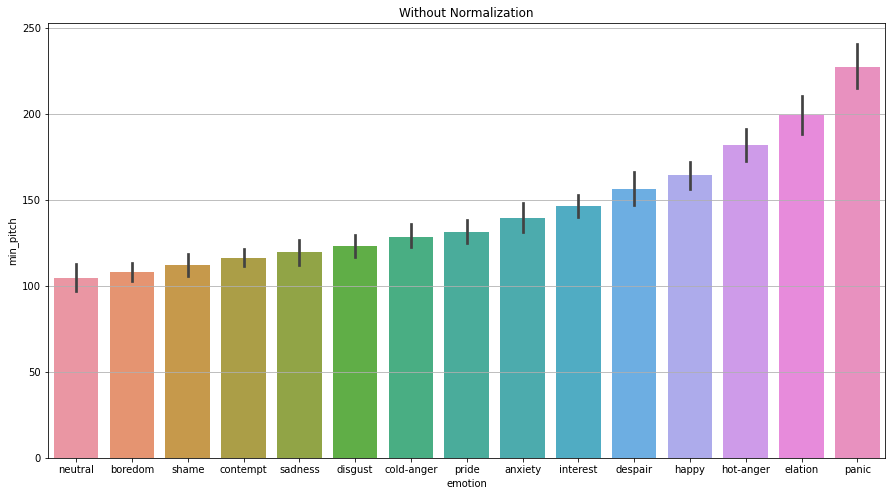

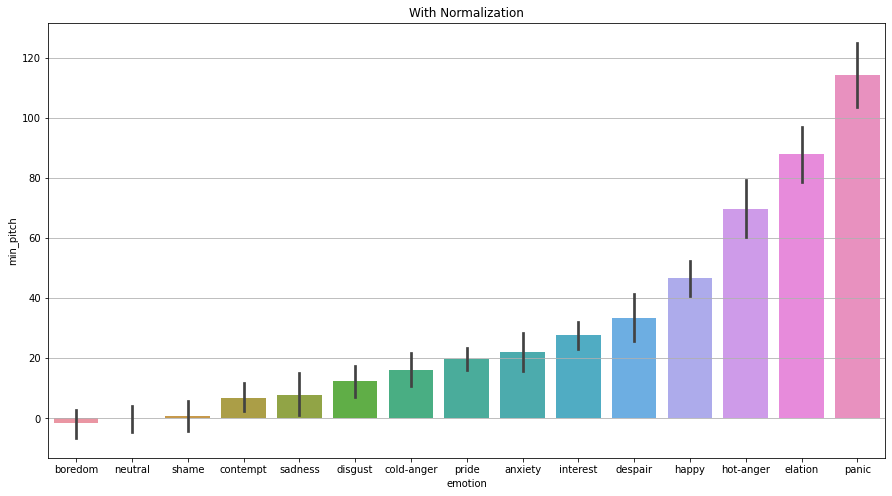

Feature: max_pitch


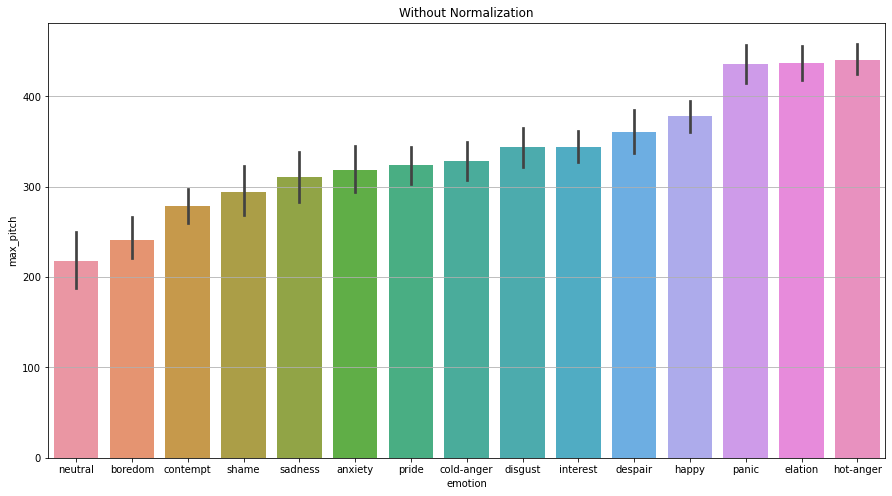

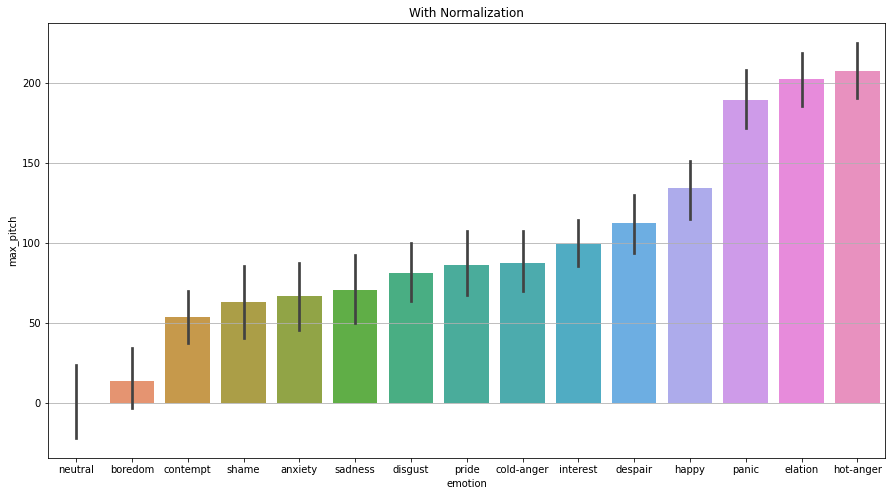

Feature: mean_pitch


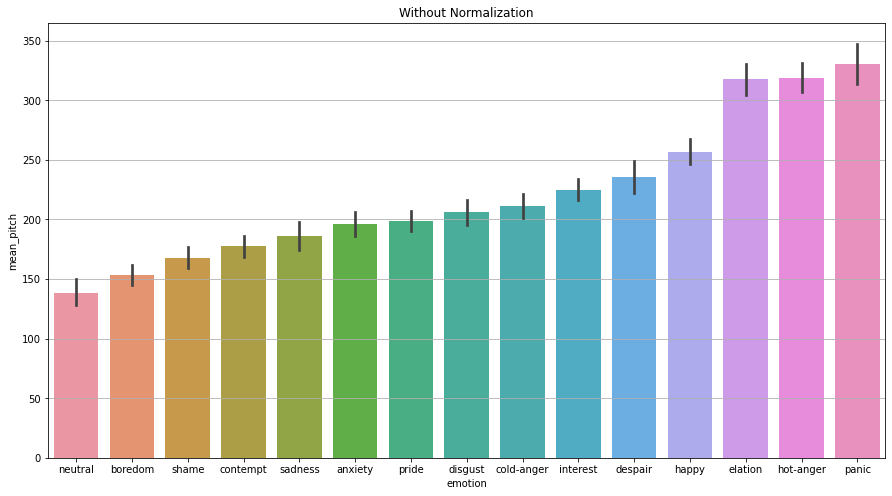

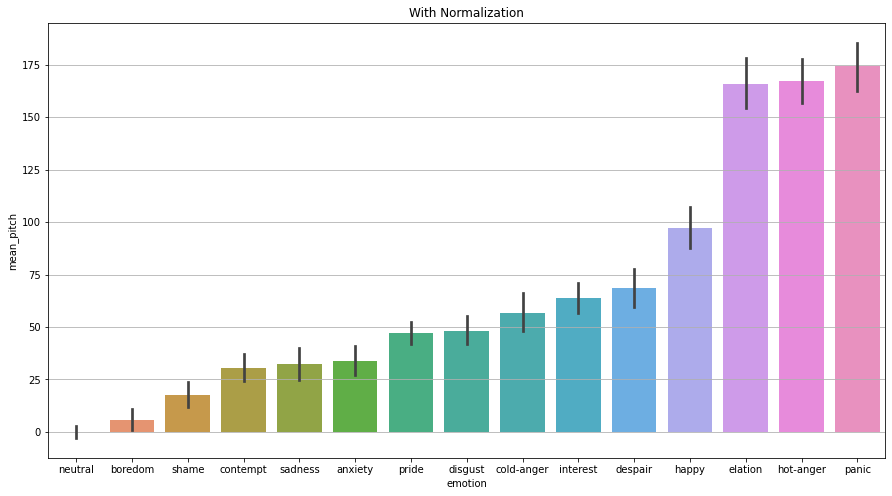

Feature: min_intensity


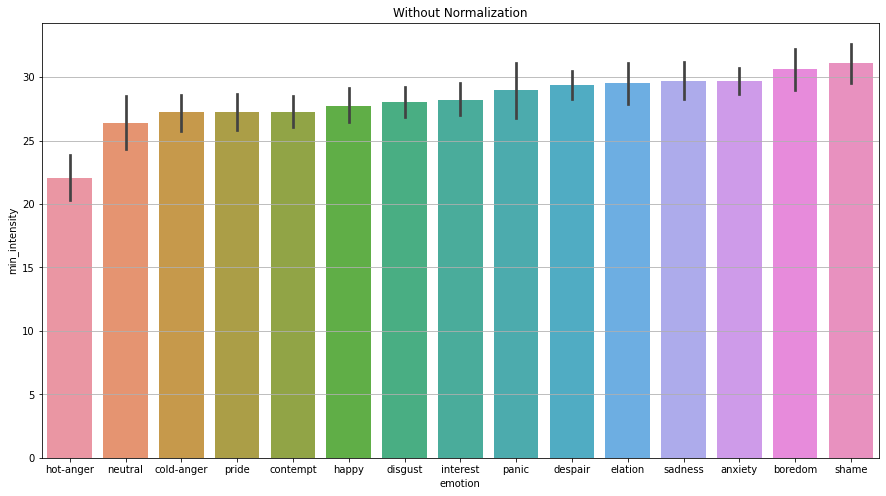

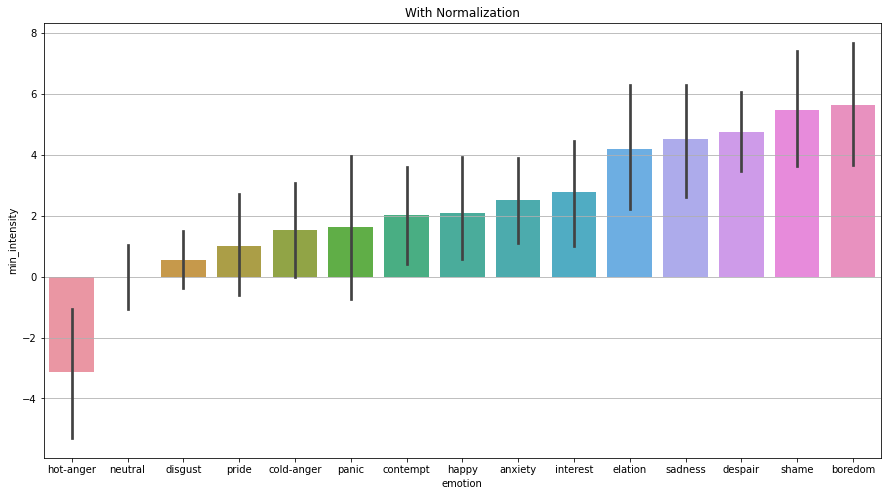

Feature: max_intensity


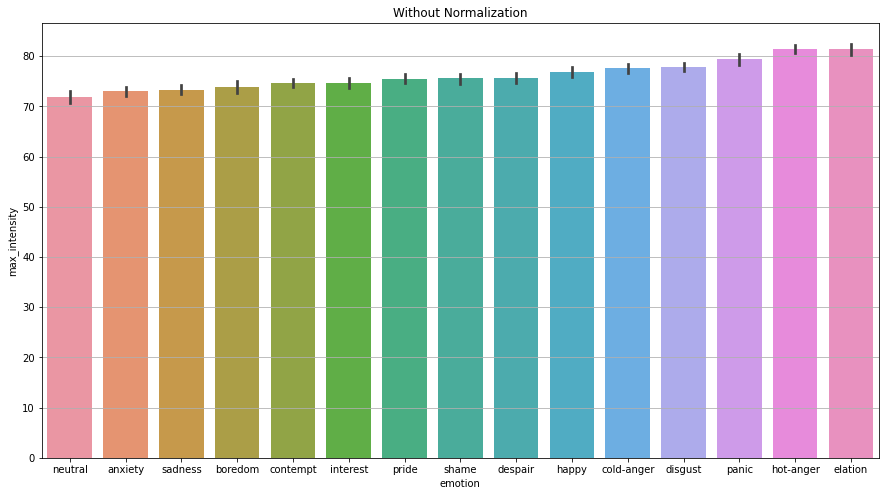

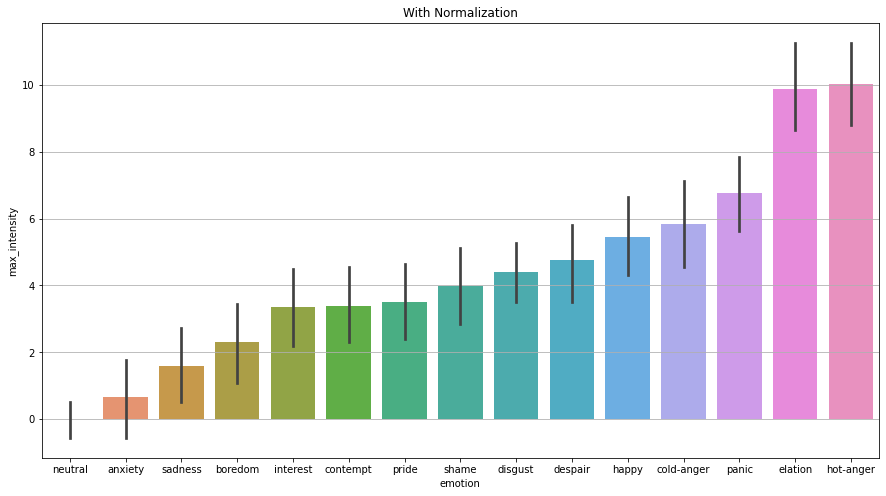

Feature: mean_intensity


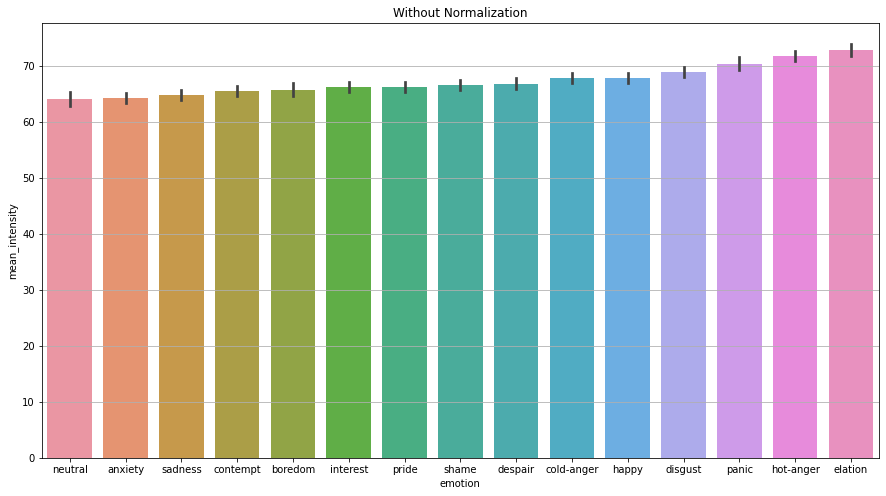

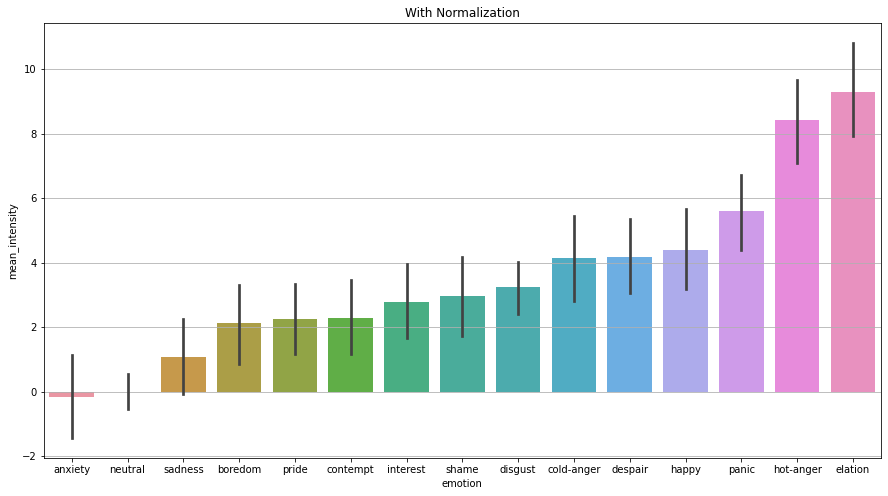

In [182]:
'''
You need to turn in plots of the mean and standard deviation of each feature for all of the 15
emotion classes. 
- Please also specify for each plot whether it was created a) without
normalization; b) with normalization (tell us what normalization method you used, how you
calculated it, and why you chose this method). Specifically, create 2 plots for each feature, one
without normalization, and one with normalization. In each plot, visualize the emotion-level mean
and standard deviation values (calculated using all speech files of a certain emotion) for all
emotion classes. You can use graphs with error bars to visualize the mean and standard
deviation, as illustrated in the examples in Figure 1, where the x-axes can be emotion classes,
and the y-axes can be any one of the 6 feature values (e.g. min pitch, mean intensity, etc.). This
will result in 12 (6 x 2)  plots. 

- Then tell us what you learn from these plots. Please report and
discuss at least 5 interesting observations.
'''

for feature in df.columns[2:]:
    print(f"Feature: {feature}")
    order = df.groupby("emotion")[feature].mean().sort_values().index
    order_norm = df_norm.groupby("emotion")[feature].mean().sort_values().index
    plt.figure(figsize=(15,8))
    plt.grid("on")
    plt.title("Without Normalization")
    sns.barplot(data=df, x=df.emotion, y=df[feature], order=order)
    plt.figure(figsize=(15,8))
    plt.grid("on")
    plt.title("With Normalization")
    sns.barplot(data=df_norm, x=df_norm.emotion, y=df_norm[feature], order=order_norm)
    plt.show()

Feature: min_pitch


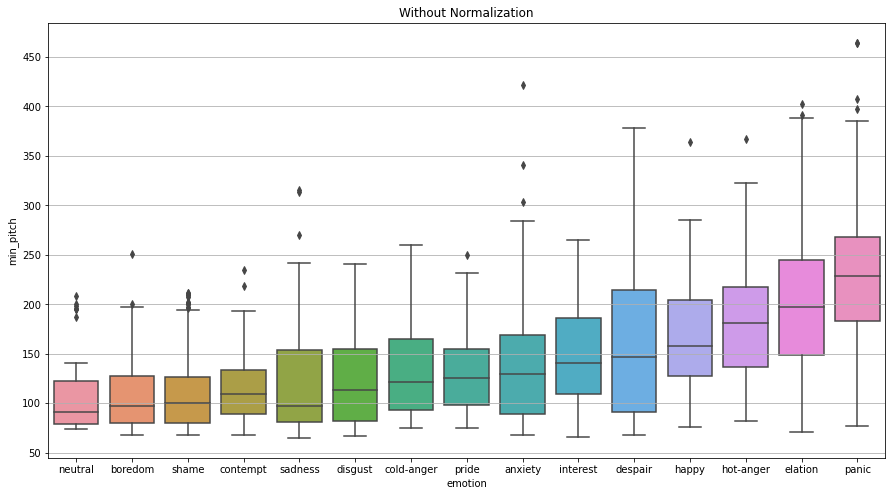

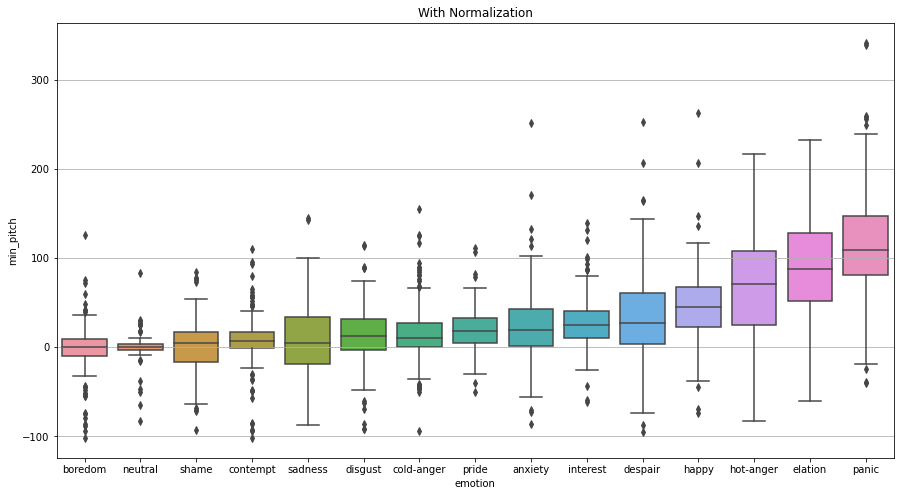

Feature: max_pitch


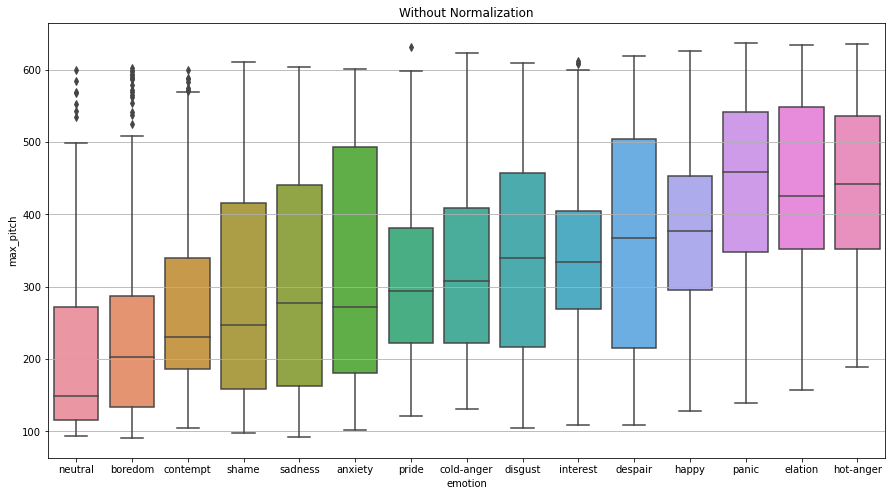

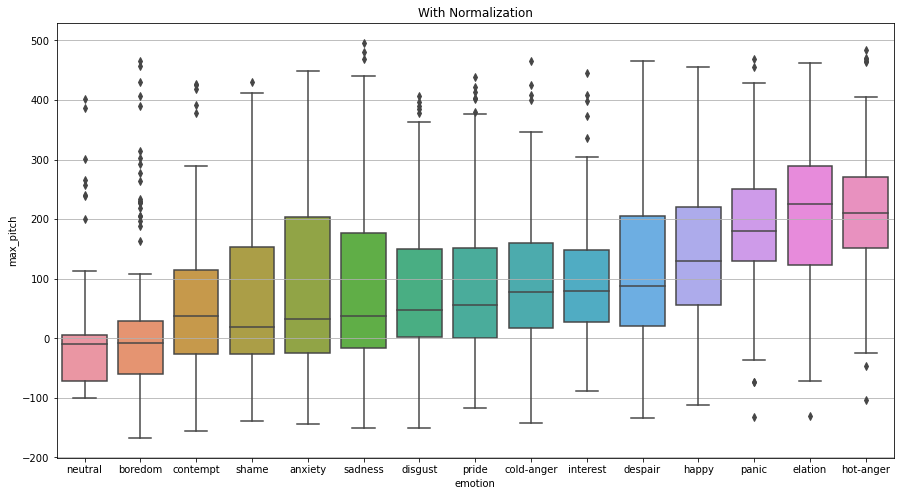

Feature: mean_pitch


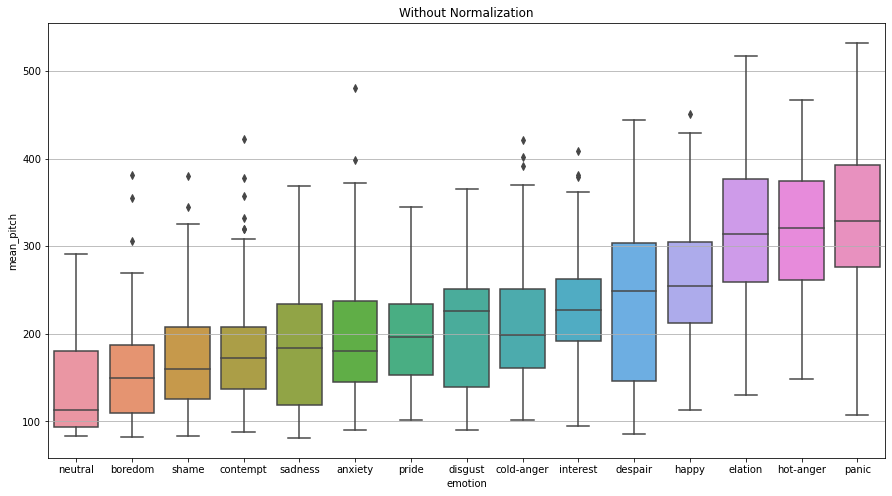

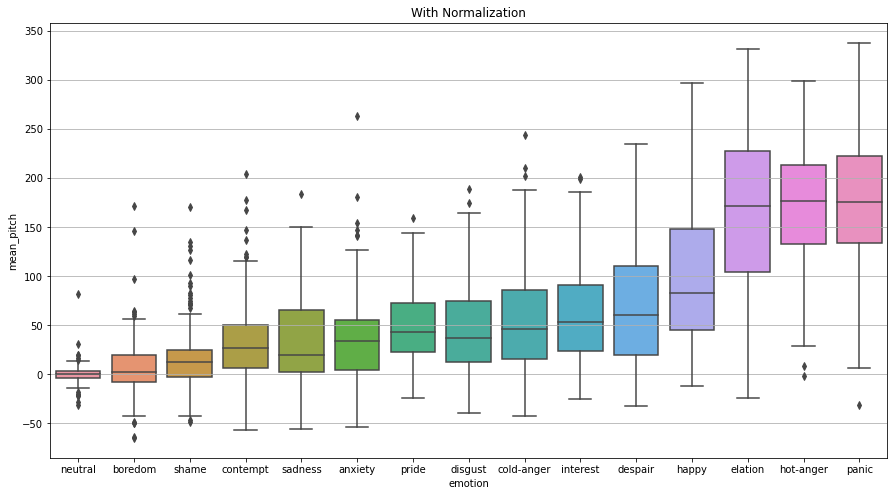

Feature: min_intensity


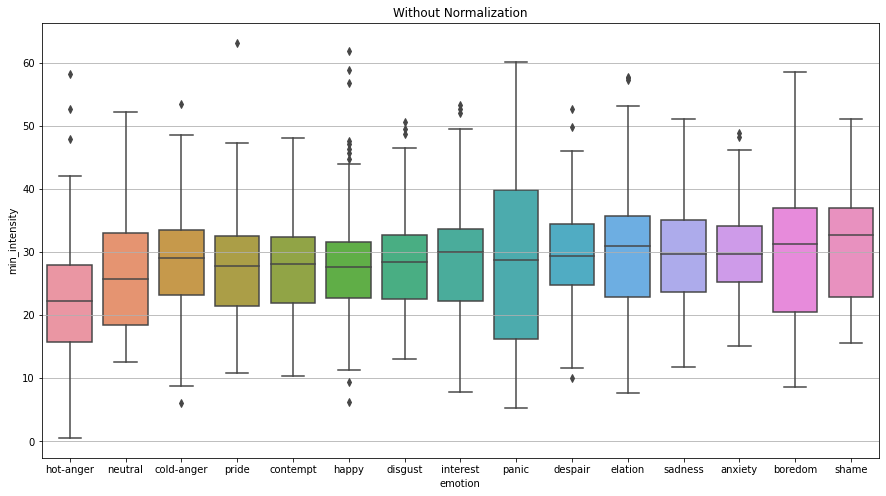

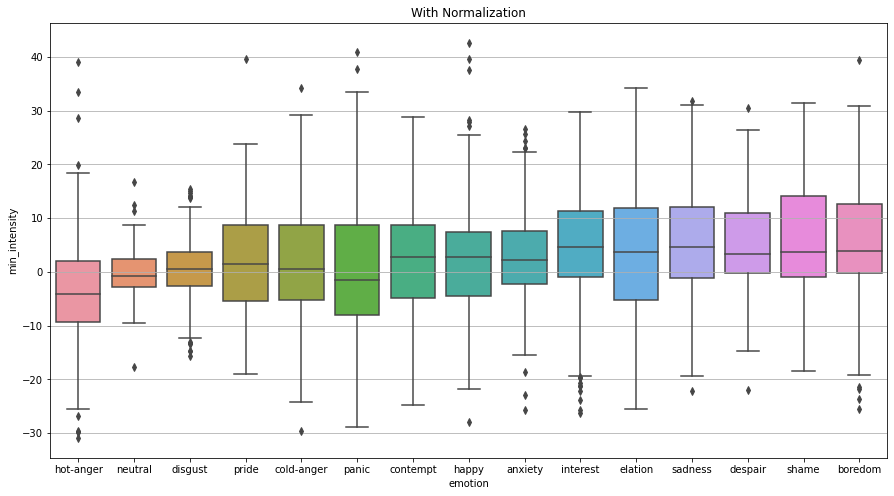

Feature: max_intensity


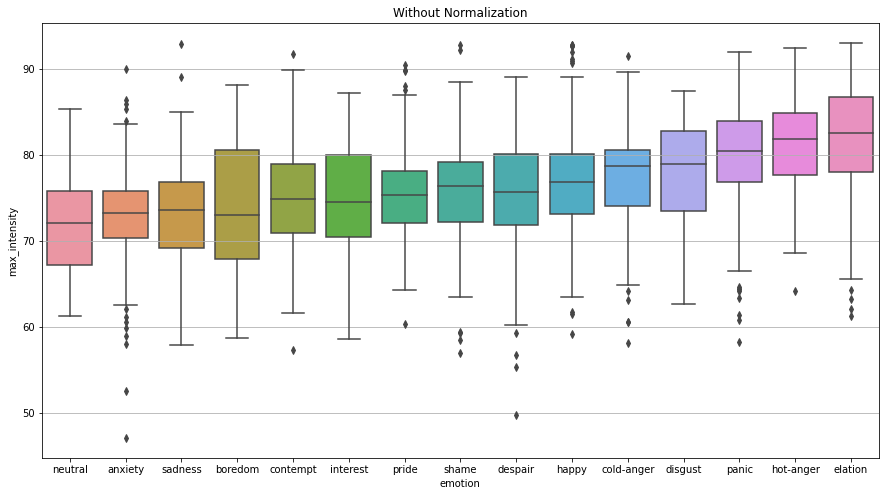

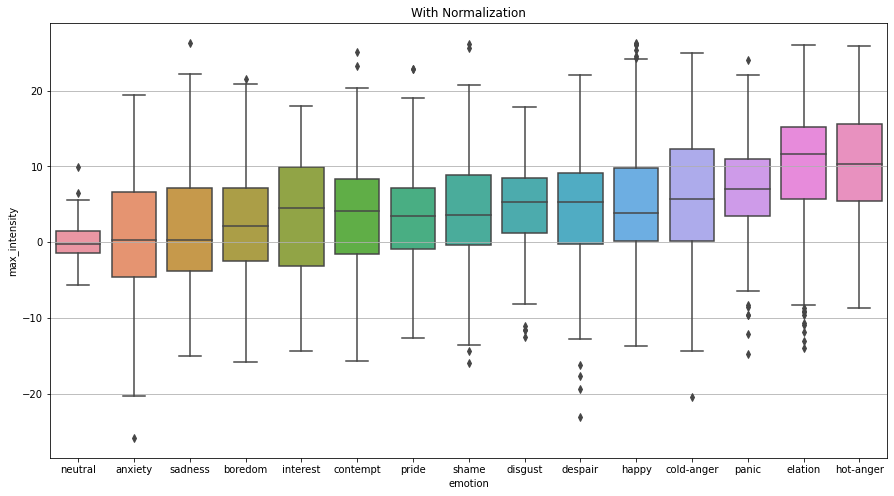

Feature: mean_intensity


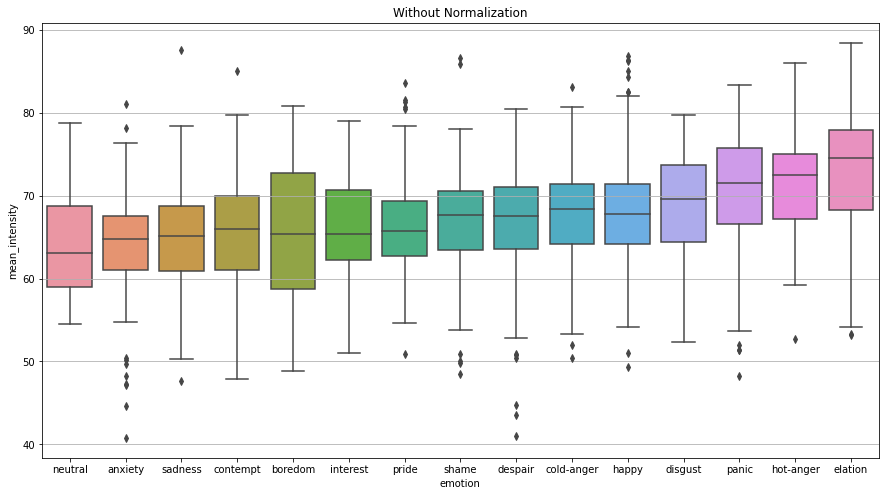

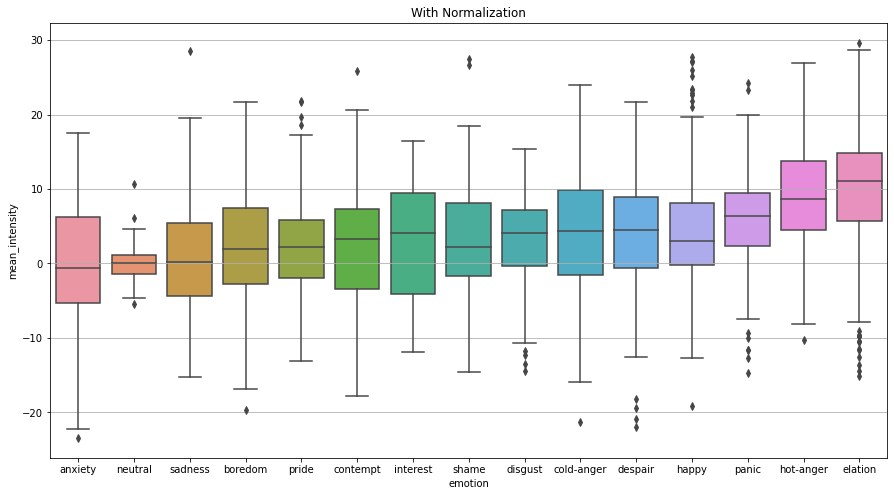

In [183]:
for feature in df.columns[2:]:
    print(f"Feature: {feature}")
    order = df.groupby("emotion")[feature].mean().sort_values().index
    order_norm = df_norm.groupby("emotion")[feature].mean().sort_values().index
    plt.figure(figsize=(15,8))
    plt.grid("on")
    plt.title("Without Normalization")
    sns.boxplot(data=df, x=df.emotion, y=df[feature], order=order)
    plt.figure(figsize=(15,8))
    plt.grid("on")
    plt.title("With Normalization")
    sns.boxplot(data=df_norm, x=df_norm.emotion, y=df_norm[feature], order=order_norm)
    plt.show()